In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# establish connection
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Calculate the date 1 year ago from the last data point in the database

final = dt.datetime.strptime(list(np.ravel(session.query(Measurement.date).order_by(Measurement.date.desc()).first()))[0], '%Y-%m-%d')

finalYear = int(dt.datetime.strftime(final, '%Y'))
finalMonth = int(dt.datetime.strftime(final, '%m'))
finalDay = int(dt.datetime.strftime(final, '%d'))

timeDif = dt.date(finalYear, finalMonth, finalDay) - dt.timedelta(days=365)

print(finalYear)
print(finalMonth)
print(finalDay)


2017
8
23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

compilation = pd.DataFrame((session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > timeDif).order_by(Measurement.date).all()))

compilation['date'] = compilation['date'].astype('datetime64[ns]')

compilation.rename(columns = {'prcp':'Precipitation'}, inplace=True) 

compilation.set_index('date', inplace=True)

# Sort the dataframe by date

compilation.sort_values("date", ascending=False)

compilation.head()

,Precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data

compilation.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


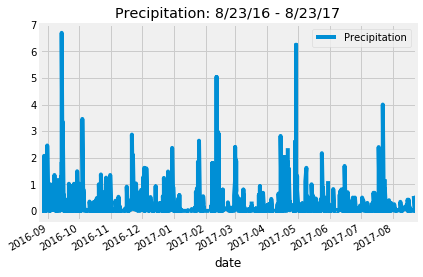

In [14]:
compilation = compilation.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
compilation.plot(title="Precipitation: 8/23/16 - 8/23/17")

![precipitation](Images/precipitation.png)

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data

compilation.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [16]:
# Design a query to show how many stations are available in this dataset?

stationNum = session.query(Station).count()
print (f'{stationNum} stations.')

9 stations.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

measureNum = (session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all())
measureNum

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

highTempQuery = (session.query(Measurement.tobs).filter(Measurement.station == measureNum[0][0]).order_by(Measurement.tobs.desc()).first())
highTemp = highTempQuery[0]

lowTempQuery = (session.query(Measurement.tobs).filter(Measurement.station == measureNum[0][0]).order_by(Measurement.tobs.asc()).first())
lowTemp = lowTempQuery[0]

avgTempQuery = (session.query(func.avg(Measurement.tobs)).filter(Measurement.station == measureNum[0][0]))
avgTemp = '{0:.3}'.format(avgTempQuery[0][0])
print(f'{lowTemp}, {highTemp}, {avgTemp}')


54.0, 85.0, 71.7


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperatures = pd.DataFrame((session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > timeDif).filter(Measurement.station == measureNum[0][0]).order_by(Measurement.date).all()))

temperatures.rename(columns = {'tobs':'Temperature (F)'}, inplace=True) 

temperatures = temperatures.set_index('date').sort_index(ascending=True)

temperatures.head()

,Temperature (F)
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


Text(0, 0.5, 'Frequency')

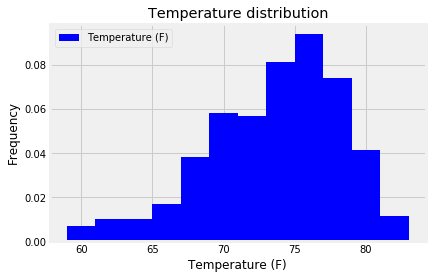

In [21]:
#histogram plot with pandas
temperatures.plot(kind='hist', bins=12, density=True, facecolor='b')

plt.title('Temperature distribution')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')

![precipitation](Images/station-histogram.png)

In [22]:
# Function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#trip  from 2020-06-06 until 2020-07-06

tripTemps = calc_temps('2017-06-06', '2017-07-06')

tripTemps

[(71.0, 77.31088082901555, 87.0)]

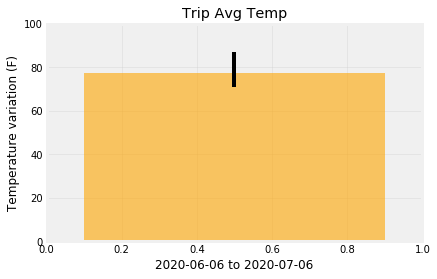

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

error = np.array([[tripTemps[0][1] - tripTemps[0][0]], [tripTemps[0][2] - tripTemps[0][1]]])

plt.bar(0.5, tripTemps[0][1], yerr=error, color = 'orange', alpha = .6)
plt.ylim(0, 100)
plt.xlim(0, 1)
plt.title('Trip Avg Temp')
plt.xlabel('2020-06-06 to 2020-07-06')
plt.ylabel('Temperature variation (F)')
plt.grid(alpha=.3)

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = ([Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation])

stationRain = pd.DataFrame(np.array(session.query(*sel).filter(Station.station == Measurement.station).filter(Measurement.date >= '2017-06-06').filter(Measurement.date <= '2017-07-06').group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()))

stationRain = stationRain.rename(columns={0: "Station", 1: "Location", 2: "Total Precipitation", 3: "Latitude", 4: "Longitude", 5: "Elevation"}, inplace=False)

stationRain.head()


,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",9.479999999999995,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",4.37,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",2.769999999999999,21.4234,-157.8015,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2.22,21.5213,-157.8374,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.7600000000000002,21.33556,-157.71139,19.5


## Optional Challenge Assignment

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


start = '2017-06-06'
end ='2017-07-06'

dates = session.query(Measurement.date).filter(Measurement.date >= start).filter(Measurement.date <= end).group_by(Measurement.date).all()

tripDays = [x[0] for x in dates]

tripDays2 = [x[5:] for x in tripDays]

initial = tripDays2[0]
last = tripDays2[-1]

   
normals = [session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= initial).filter(func.strftime("%m-%d", Measurement.date) <= last).group_by(func.strftime("%m-%d", Measurement.date)).all()]

normals = normals[0]

normals

[(70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0),
 (70.0, 75.58620689655173, 81.0),
 (69.0, 75.15254237288136, 81.0),
 (68.0, 75.14285714285714, 81.0),
 (69.0, 76.01960784313725, 84.0),
 (66.0, 75.66666666666667, 83.0),
 (68.0, 75.66666666666667, 81.0),
 (69.0, 75.62711864406779, 81.0),
 (67.0, 75.40350877192982, 81.0),
 (69.0, 75.41379310344827, 81.0),
 (68.0, 74.59322033898304, 81.0),
 (69.0, 74.60344827586206, 80.0),
 (70.0, 75.44067796610169, 82.0),
 (68.0, 73.96491228070175, 85.0),
 (68.0, 74.75862068965517, 82.0),
 (69.0, 75.15789473684211, 81.0),
 (68.0, 74.54385964912281, 80.0),
 (68.0, 74.96428571428571, 84.0),
 (68.0, 74.10344827586206, 80.0),
 (67.0, 74.21428571428571, 82.0),
 (66.0, 75.01785714285714, 81.0),
 (69.0, 74.88679245283019, 80.0),
 (67.0, 74.91525423728814, 80.0),
 (67.0, 75.59615384615384, 81.0),
 (67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 

In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normalsdf= pd.DataFrame(normals,columns=['tmin', 'tavg', 'tmax'])

normalsdf['date']= tripDays

normalsdf['date'] = pd.to_datetime(normalsdf['date'], format='%Y-%m-%d')

normalsdf.set_index('date',inplace=True)

normalsdf

,tmin,tavg,tmax
date,,,
2017-06-06,70.0,75.175439,80.0
2017-06-07,68.0,75.071429,81.0
2017-06-08,70.0,75.586207,81.0
2017-06-09,69.0,75.152542,81.0
2017-06-10,68.0,75.142857,81.0
2017-06-11,69.0,76.019608,84.0
2017-06-12,66.0,75.666667,83.0
2017-06-13,68.0,75.666667,81.0
2017-06-14,69.0,75.627119,81.0


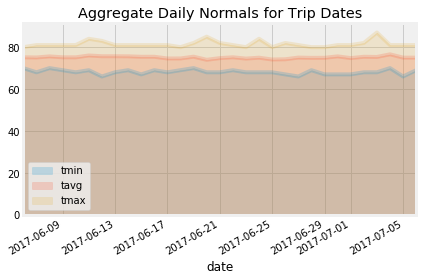

In [36]:
# Plot the daily normals as an area plot with `stacked=False`

normalsdf.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
plt.show()